In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForSeq2SeqLM, BartForConditionalGeneration,BartTokenizer
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from shap.utils import assert_import, record_import_error, safe_isinstance, make_masks, OpChain, MaskedModel
from shap import maskers, links
from transformers.file_utils import ModelOutput

In [2]:
tokenizer = BartTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
#tokenizer = AutoTokenizer.from_pretrained('bart-large')
model =  BartForConditionalGeneration.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

In [3]:
dataset = nlp.load_dataset('xsum',split='train')

WARNING - Using custom data configuration default


In [4]:
def summarize(x,model,tokenizer,mask=None):
    print(f"Masked input: {x}")
    inputs = tokenizer([x], max_length=1024, return_tensors='pt')
    input_ids=inputs['input_ids'].cuda()
    if mask is not None:
        attention_mask=torch.tensor(mask).unsqueeze(0).type(torch.int64).cuda()
    if mask:
        summary_ids = model.generate(input_ids,attention_mask=attention_mask)
    else:
        summary_ids = model.generate(input_ids)
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    print(f"summary: {summary[0]}")

#### Examples

In [187]:
summarize(dataset['document'][1],model,tokenizer)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Masked input: Knight was shot in the leg by an unknown gunman at Miami's Shore Club where West was holding a pre-MTV Awards celebration.At least six shots were fired, but few witnesses came forward and no-one has been ever arrested over what happened.Celebrities like Jessica Alba and the Black Eyed Peas were all at the event.Marion "Suge" Knight, a controversial figure in the hip hop community, helped launch the careers of rappers like Tupac Shakur and Snoop Dogg.The 44-year-old is claiming that Kanye West and the club's owners didn't provide enough security to keep people with weapons out of the venue.Knight's lawyer, Marc Brumer, said: "He had an expectation of security there. How someone came with a gun into a very VIP party, that just doesn't meet the smell test in life."Knight is also seeking more than Â£650,000 in damages, which includes compensation for a 15-carat diamond earring he says was lost in the chaos.He also claims that he had to pay Â£130,000 in medical bills due to a 

#### Single instance with all context example

In [5]:
inputs = tokenizer([dataset['document'][0]], max_length=1024, return_tensors='pt',min_length=0)
input_ids=inputs['input_ids'].cuda()
out=model.generate(input_ids,return_dict=True)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


In [6]:
decoder_inputs=out[:,:-1]

In [7]:
encoder = model.get_encoder()
attention_mask = (input_ids!=tokenizer.pad_token_id).type(torch.int64).cuda()
encoder_outputs: ModelOutput = encoder(input_ids, attention_mask=attention_mask, return_dict=True)

In [8]:
def cal_conditional_logits(encoder_outputs,attention_mask):
    conditional_logits=[]
    past=None
    for i in range(1,decoder_inputs.shape[1]):
        #print(decoder_inputs[:,:i])
        model_inputs = model.prepare_inputs_for_generation(
                    decoder_inputs[:,:i], past=past, attention_mask=attention_mask, use_cache=True, encoder_outputs=encoder_outputs
                )
        outputs = model(**model_inputs, return_dict=True)
        if "past_key_values" in outputs:
            past = outputs.past_key_values
        next_token_logits = outputs.logits[:, -1, :]
        #print(torch.argmax(next_token_logits, dim=-1))
        probs=next_token_logits[0].softmax(dim=0)
        #values, predictions = probs.topk(1)
        #print(tokenizer.decode(predictions).split())
        probs=probs.detach().cpu().numpy()
        #val = sp.special.logit(probs)
        conditional_logits.append(probs[decoder_inputs[0,i].item()])
    #print(conditional_logits)
    token_ids=tokenizer.convert_ids_to_tokens(decoder_inputs[0,1:].detach().cpu().numpy())
    mlp.rcParams['figure.figsize']=(10,5)
    plt.bar(token_ids,conditional_logits)
    plt.xticks(rotation=90)
    plt.show()
    return conditional_logits

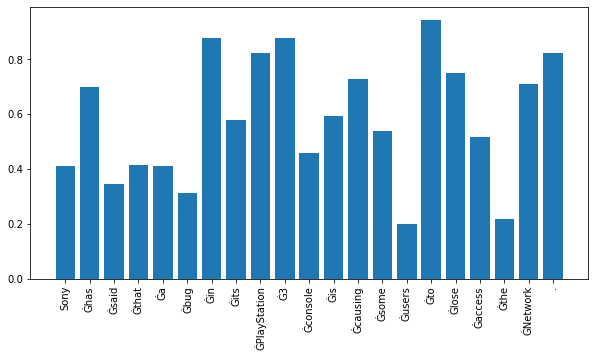

[0.41052395,
 0.7006684,
 0.34734645,
 0.41565365,
 0.41078216,
 0.31418768,
 0.8768168,
 0.57865644,
 0.82433105,
 0.87740356,
 0.45863608,
 0.59361595,
 0.7278262,
 0.5403293,
 0.19839579,
 0.8983806,
 0.74890614,
 0.51526415,
 0.94386387,
 0.2197351,
 0.6107581,
 0.71034175,
 0.8229854]

In [184]:
cal_conditional_logits(encoder_outputs,attention_mask)

#### Example of an article and its summary

In [238]:
dataset['document'][22]

'Abdiwali Abdiqadir Muse now faces a minimum of 27 years in prison. He is expected to be sentenced in October.Muse is the only surviving attacker of the Maersk Alabama merchant ship off Somalia\'s coast in April 2009.He was captured by the US Navy, whose sharpshooters killed three other pirates trying to escape on a lifeboat, saving the captain.During the trial in federal court in Manhattan, prosecutors described Muse as a ringleader of a gang of four pirates who seized the Maersk Alabama some 450km (280 miles) off the coast of Somalia.A criminal complaint also said Muse was the first to board the vessel, firing his AK-47 assault rifle at Captain Richard Phillips.On Tuesday, Muse said through an interpeter: "I am very, very sorry about what we did. All of this was about the problems in Somalia."It is said to be the first piracy trial in the US in decades.The vessel, which was carrying food aid, was seized by the four pirates in April 2009.Capt Phillips then told his crew to lock themse

In [9]:
dataset['summary'][0]

'The winners of a TV talent show have beaten the Pope to the album of the year at the Classical Brit Awards.\n'

#### Define function

In [168]:
def f(x_batch):
    output_batch=[]
    for i,x in enumerate(x_batch):
        print(f"\033[1m Masked input: \033[0m {x}")
        inputs = tokenizer([x], max_length=1024, return_tensors='pt',truncation=True)
        input_ids=inputs['input_ids'].cuda()
        summary_ids = model.generate(input_ids,num_beams=1)
        summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
        print(f"\033[1m Summary: \033[0m {summary[0]} \n")
        output_batch.append(summary)
    return output_batch

In [9]:
def f_cp(x_batch):
    output_batch=[]
    for i,x in enumerate(x_batch):
        print(f"\033[1m Masked input: \033[0m {x}")
        inputs = tokenizer([x], max_length=1024, return_tensors='pt',truncation=True)
        input_ids=inputs['input_ids'].cuda()
        #print(input_ids)
        encoder = model.get_encoder()
        attention_mask = (input_ids!=tokenizer.pad_token_id).type(torch.int64).cuda()
        encoder_outputs: ModelOutput = encoder(input_ids, attention_mask=attention_mask, return_dict=True)
        summary_ids = model.generate(input_ids,num_beams=1)
        summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
        print(f"\033[1m Summary: \033[0m {summary[0]} \n")
        conditional_logits = cal_conditional_logits(encoder_outputs,attention_mask)
        #print(f'Conditional logits: {conditional_logits}')
        output_batch.append(summary)
    return output_batch

In [17]:
explainer = shap.Explainer(f_cp,tokenizer)
explainer.masker.mask_token=None
explainer.masker.mask_token_str=""
row_args=(dataset['document'][22],)
fm = MaskedModel(explainer.model, explainer.masker, explainer.link,*row_args)
explainer._clustering = explainer.masker.clustering(*row_args)
explainer._mask_matrix = make_masks(explainer._clustering)

explainers.Partition is still in an alpha state, so use with caution...


In [18]:
'''
M = len(fm)
mask_index=205
m00 = np.zeros(M, dtype=np.bool)
m_new=m00.copy()
m_new[:]+=explainer._mask_matrix[mask_index+M,:]
batch_masks=[]
batch_masks.append(m_new)
batch_masks=np.array(batch_masks)
'''

'\nM = len(fm)\nmask_index=205\nm00 = np.zeros(M, dtype=np.bool)\nm_new=m00.copy()\nm_new[:]+=explainer._mask_matrix[mask_index+M,:]\nbatch_masks=[]\nbatch_masks.append(m_new)\nbatch_masks=np.array(batch_masks)\n'

#### Plotting hierarchical clustering over text

In [19]:
feature_names = [explainer.masker.tokenizer.decode([v]) for v in explainer.masker._tokenized_s]

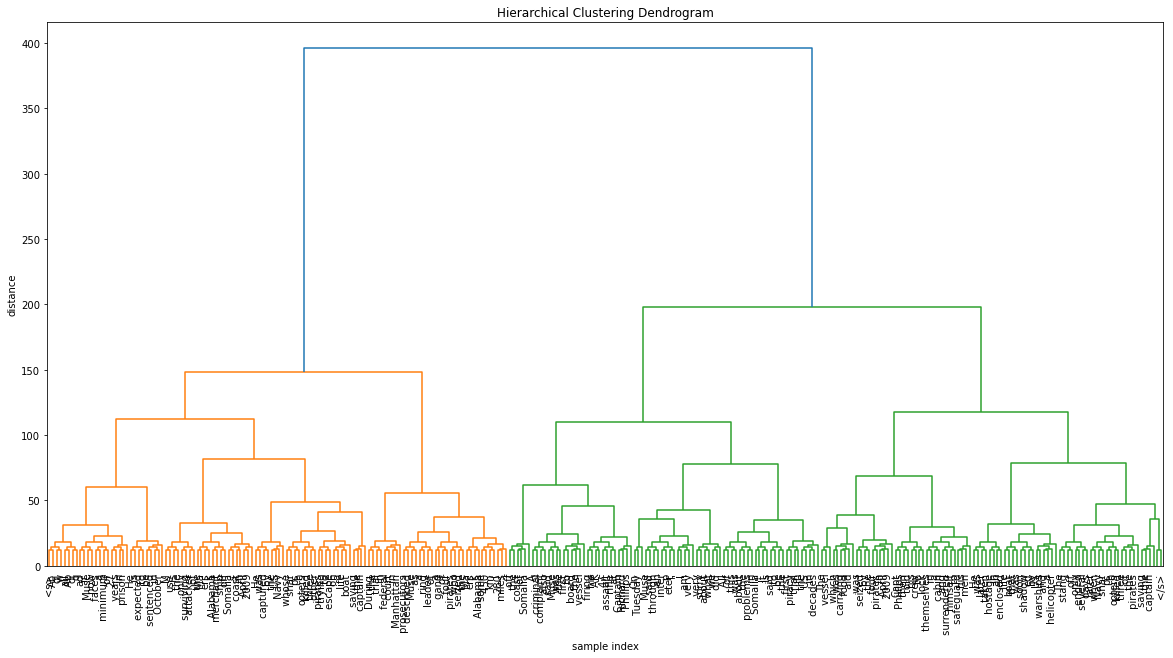

In [22]:
# plot the clustering
mlp.rcParams['figure.figsize']=(20,10)
#plt.figure(figsize=(25, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    explainer._clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=feature_names,
)
plt.show()

In [13]:
def masking_experiment(clust_index,d,d_limit,feature_names,M):
    if d>d_limit:
        return
    #print(f'clust_index:{clust_index}')
    m00 = np.zeros(M, dtype=np.bool)
    m_new=m00.copy()
    mask_index=clust_index+M
    #print(f'mask_index:{mask_index}')
    m_new[:]+=explainer._mask_matrix[mask_index,:]
    batch_masks=[]
    batch_masks.append(m_new)
    batch_masks=np.array(batch_masks)
    fout = fm(batch_masks)
    #print(f'Masked string: {feature_names[m_new]}')
    lind,rind=[int(x) for x in explainer._clustering[clust_index,:2]]
    #print(f'lind:{lind} rind:{rind}')
    masking_experiment(lind-M if lind>=M else lind,d+1,d_limit,feature_names,M)
    masking_experiment(rind-M if rind>=M else rind,d+1,d_limit,feature_names,M)
    

In [14]:
def reference_evaluation(M):
    m00 = np.zeros(M, dtype=np.bool)
    batch_masks=[]
    batch_masks.append(m00)
    batch_masks=np.array(batch_masks)
    fout = fm(batch_masks)

In [190]:
d=0
d_limit=3
M = len(fm)
clust_index=M-2
reference_evaluation(M)
masking_experiment(clust_index,d,d_limit,np.array(feature_names),M)

 Masked input:  
 Summary:   restrooms are usually reserved for women... and 

 Masked input:  The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play t

In [23]:
inputs = tokenizer([dataset['document'][22]], max_length=1024, return_tensors='pt',min_length=0)
input_ids=inputs['input_ids'].cuda()
out=model.generate(input_ids,return_dict=True,num_beams=1)
decoder_inputs=out[:,:-1]

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


 Masked input:  
 Summary:   restrooms are usually reserved for women... and 



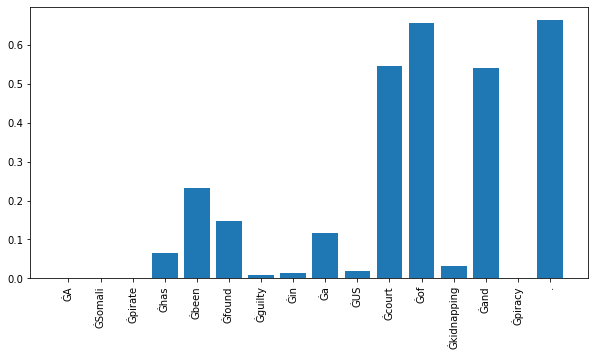

 Masked input:  Abdiwali Abdiqadir Muse now faces a minimum of 27 years in prison. He is expected to be sentenced in October.Muse is the only surviving attacker of the Maersk Alabama merchant ship off Somalia's coast in April 2009.He was captured by the US Navy, whose sharpshooters killed three other pirates trying to escape on a lifeboat, saving the captain.During the trial in federal court in Manhattan, prosecutors described Muse as a ringleader of a gang of four pirates who seized the Maersk Alabama some 450km (280 miles) off the coast of Somalia.A criminal complaint also said Muse was the first to board the vessel, firing his AK-47 assault rifle at Captain Richard Phillips.On Tuesday, Muse said through an interpeter: "I am very, very sorry about what we did. All of this was about the problems in Somalia."It is said to be the first piracy trial in the US in decades.The vessel, which was carrying food aid, was seized by the four pirates in April 2009.Capt Phillips then told his crew 

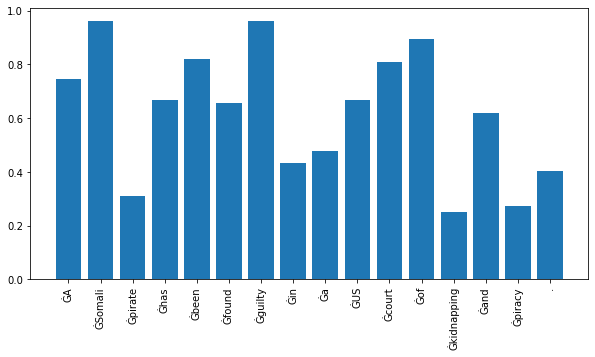

 Masked input:  Abdiwali Abdiqadir Muse now faces a minimum of 27 years in prison. He is expected to be sentenced in October.Muse is the only surviving attacker of the Maersk Alabama merchant ship off Somalia's coast in April 2009.He was captured by the US Navy, whose sharpshooters killed three other pirates trying to escape on a lifeboat, saving the captain.During the trial in federal court in Manhattan, prosecutors described Muse as a ringleader of a gang of four pirates who seized the Maersk Alabama some 450km (280 miles)
 Summary:   A Somali pirate has been found guilty by a US court of masterminding the hijacking of a ship off the coast of Somalia. 



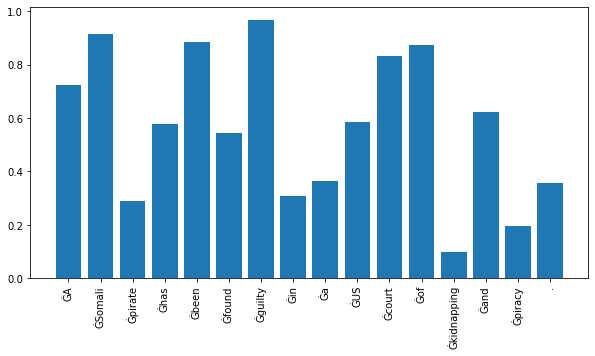

 Masked input:  Abdiwali Abdiqadir Muse now faces a minimum of 27 years in prison. He is expected to be sentenced in October.Muse is the only surviving attacker of the Maersk Alabama merchant ship off Somalia's coast in April 2009.He was captured by the US Navy, whose sharpshooters killed three other pirates trying to escape on a lifeboat, saving the captain.
 Summary:   A Somali pirate who was captured after a raid on a US ship has pleaded guilty to piracy charges in the US state of New York. 



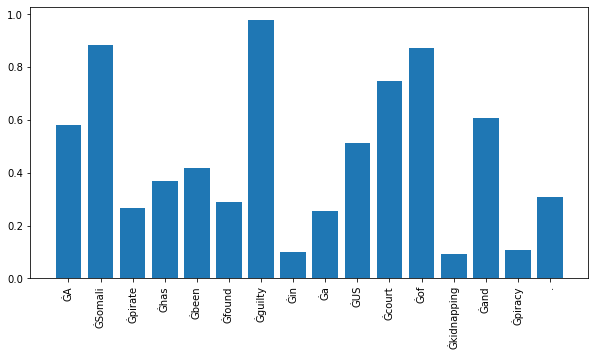

 Masked input:  Abdiwali Abdiqadir Muse now faces a minimum of 27 years in prison. He is expected to be sentenced in October.
 Summary:   A Somali man has pleaded guilty to the attempted murder of a woman in the capital, Addis Ababa. 



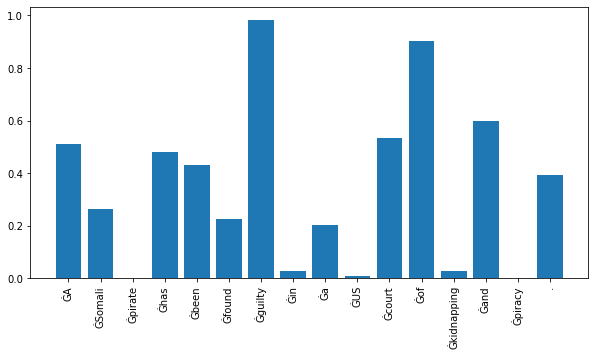

 Masked input:  Abdiwali Abdiqadir Muse now faces a minimum of 27 years in prison.
 Summary:   A man has been sentenced to life in prison for murdering a former Ethiopian police officer. 



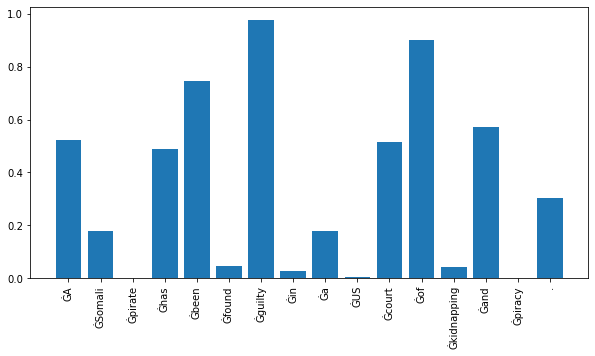

 Masked input:   He is expected to be sentenced in October.
 Summary:   The former head of the Royal Marine Corps, David Lomond, has pleaded guilty to the attempted murder of a woman in the Isle of Man. 



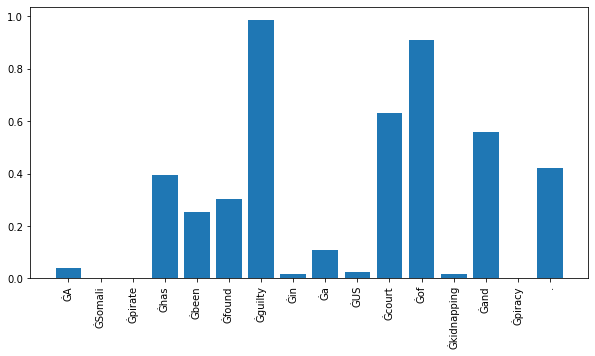

 Masked input:  Muse is the only surviving attacker of the Maersk Alabama merchant ship off Somalia's coast in April 2009.He was captured by the US Navy, whose sharpshooters killed three other pirates trying to escape on a lifeboat, saving the captain.
 Summary:   The US Navy has confirmed that former Somali pirate Ahmed Muse is one of the five men who escaped from a ship in the North Sea. 



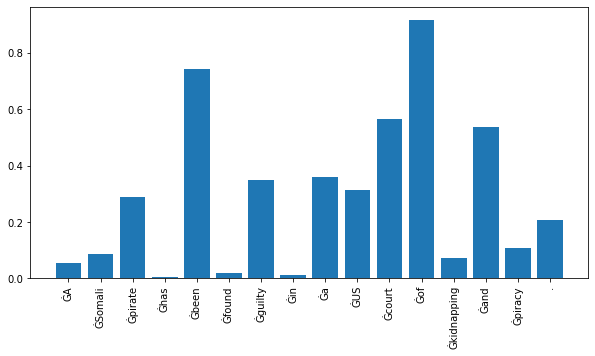

 Masked input:  Muse is the only surviving attacker of the Maersk Alabama merchant ship off Somalia's coast in April 2009.
 Summary:   The BBC has identified the man who carried out the attack on a ship in the North Sea as Mohamed Muse. 



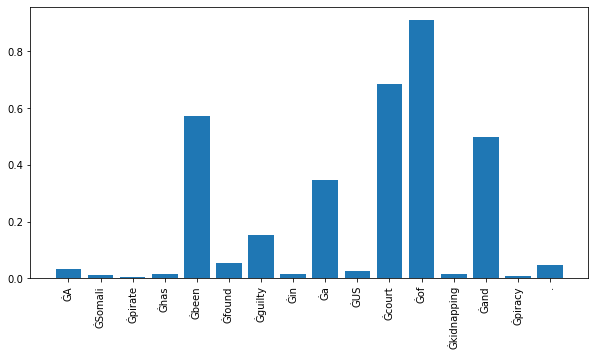

 Masked input:  He was captured by the US Navy, whose sharpshooters killed three other pirates trying to escape on a lifeboat, saving the captain.
 Summary:   The captain of the pirate ship, the Hoegh-Boat, was killed by pirates while trying to board a ship in the Mediterranean in the early hours of the morning. 



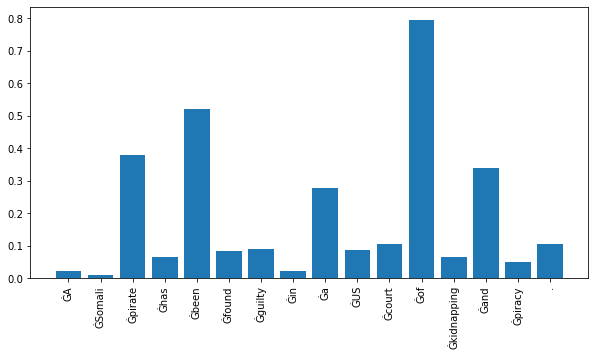

 Masked input:  During the trial in federal court in Manhattan, prosecutors described Muse as a ringleader of a gang of four pirates who seized the Maersk Alabama some 450km (280 miles)
 Summary:   The trial of former pirate Henry Muse has ended in a New York court after he was found not guilty of charges of piracy and money laundering. 



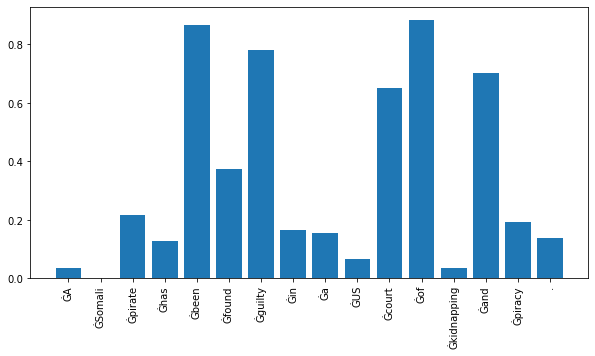

 Masked input:  During the trial in federal court in Manhattan,
 Summary:   The trial of former New York City Mayor Bill de Blasio has ended in a mistrial. 



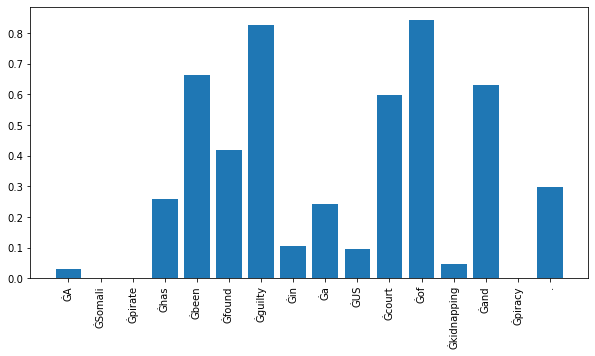

 Masked input:  During the trial in
 Summary:   The trial of former British Prime Minister David Cameron has been adjourned until the end of the year. 



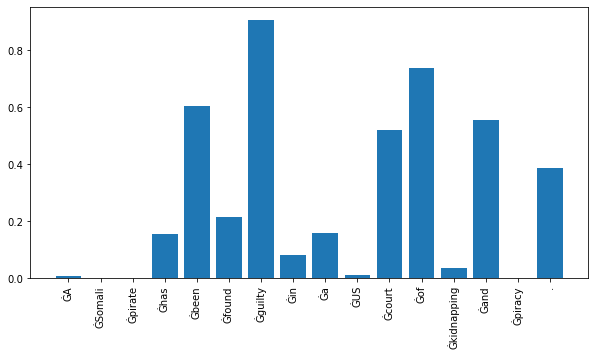

 Masked input:   federal court in Manhattan,
 Summary:   The US federal judge has ordered a $1.2bn (£1.4bn) fine for a man accused of assaulting a police officer in New York. 



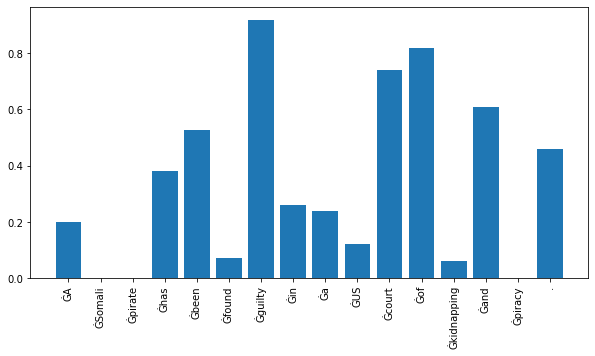

 Masked input:   prosecutors described Muse as a ringleader of a gang of four pirates who seized the Maersk Alabama some 450km (280 miles)
 Summary:   The Bahamas has extradited former pirate Henry Muse to the US for his role in the seizure of a ship in the Gulf of Mexico in 2010. 



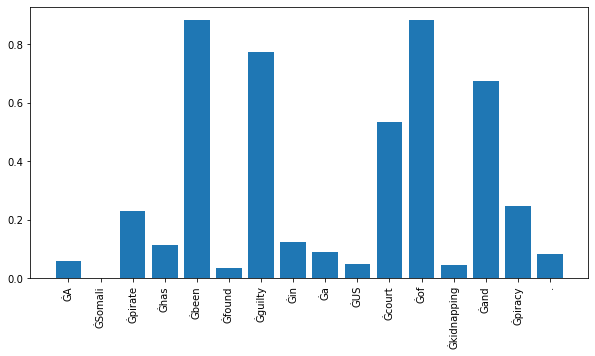

 Masked input:   prosecutors described Muse as a ringleader of a gang of four pirates who seized the
 Summary:   The former leader of the Somali pirates, Mokdim Muse, has been sentenced to life in prison for piracy. 



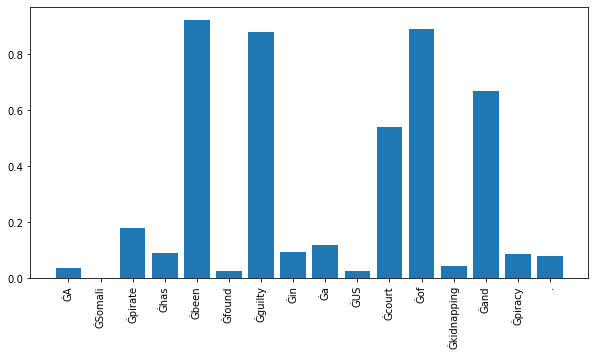

 Masked input:   Maersk Alabama some 450km (280 miles)
 Summary:   The North Sea is the longest and most northerly route in the world, with the largest container ship in the North Sea, the Maersk Alabama. 



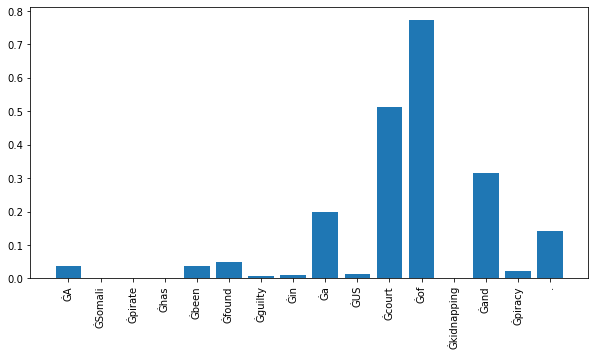

 Masked input:   off the coast of Somalia.A criminal complaint also said Muse was the first to board the vessel, firing his AK-47 assault rifle at Captain Richard Phillips.On Tuesday, Muse said through an interpeter: "I am very, very sorry about what we did. All of this was about the problems in Somalia."It is said to be the first piracy trial in the US in decades.The vessel, which was carrying food aid, was seized by the four pirates in April 2009.Capt Phillips then told his crew to lock themselves in a cabin and surrendered himself to safeguard his men.He was later taken hostage in an enclosed lifeboat that was soon shadowed by US warships and a helicopter.The stand-off only ended several days later when Navy sharpshooters killed three of the pirates, saving the captain.

 Summary:   US Navy officer James Muse has pleaded guilty to charges of kidnapping and assault on a merchant vessel in 2009. 



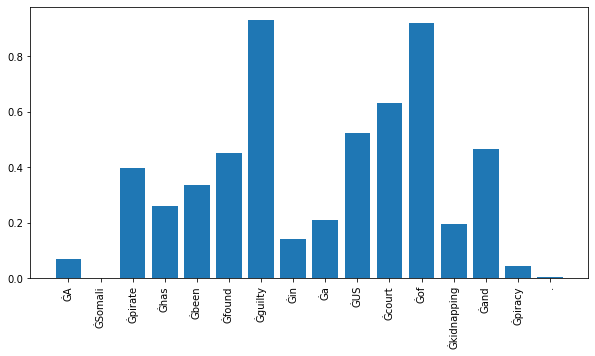

 Masked input:   off the coast of Somalia.A criminal complaint also said Muse was the first to board the vessel, firing his AK-47 assault rifle at Captain Richard Phillips.On Tuesday, Muse said through an interpeter: "I am very, very sorry about what we did. All of this was about the problems in Somalia."It is said to be the first piracy trial in the US in decades.
 Summary:   US Navy veteran James Muse has pleaded not guilty to charges that he and his crew members boarded a fishing boat in 2012. 



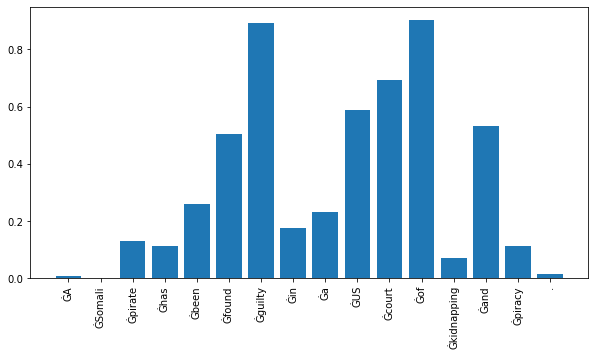

 Masked input:   off the coast of Somalia.A criminal complaint also said Muse was the first to board the vessel, firing his AK-47 assault rifle at Captain Richard Phillips.
 Summary:   The captain of the US Navy's search and seizure vessel, the USS Bounty, was killed by a gunman who was on board, US prosecutors said. 



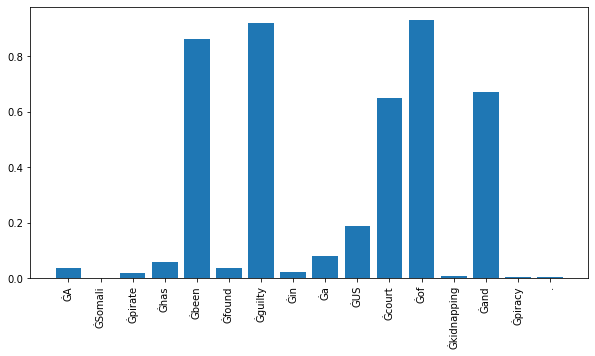

 Masked input:   off the coast of Somalia.
 Summary:   The UN has suspended all international operations in the Arabian Sea, citing "serious concerns" over the safety of the vessels. 



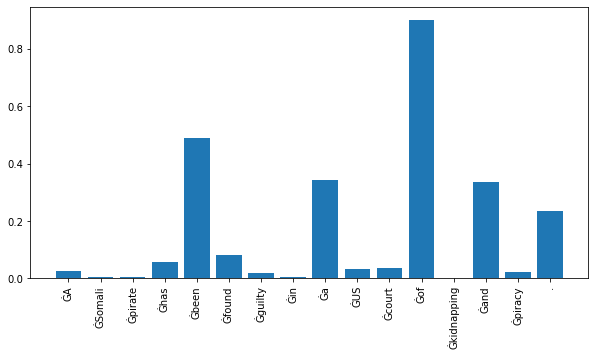

 Masked input:  A criminal complaint also said Muse was the first to board the vessel, firing his AK-47 assault rifle at Captain Richard Phillips.
 Summary:   The man accused of shooting dead the captain of the USS Bounty in 2012, James Muse, has been charged with murder. 



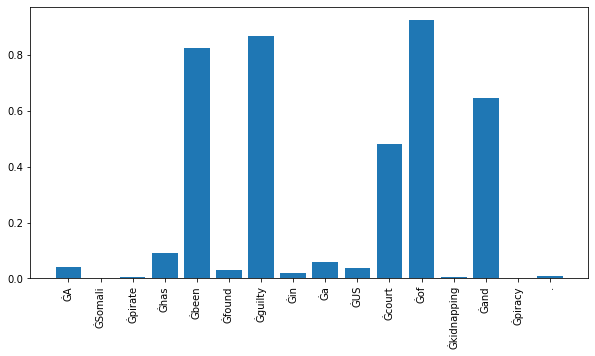

 Masked input:  On Tuesday, Muse said through an interpeter: "I am very, very sorry about what we did. All of this was about the problems in Somalia."It is said to be the first piracy trial in the US in decades.
 Summary:   The former US Navy captain, John Muse, has pleaded guilty to charges of piracy and other crimes, but has said he will not stand trial. 



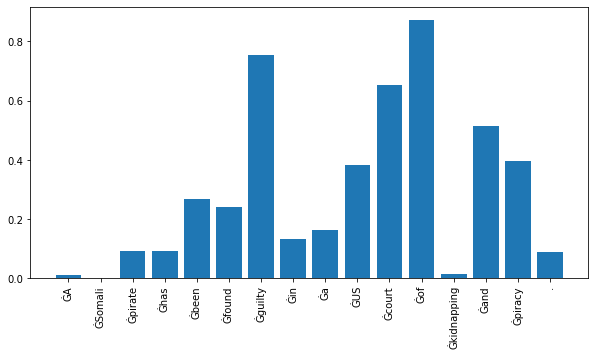

 Masked input:  On Tuesday, Muse said through an interpeter: "I am very, very sorry about what we did.
 Summary:   Singer-songwriter Muse has apologised for the way her music was played in the UK, including the "unacceptable" way of handling the issue. 



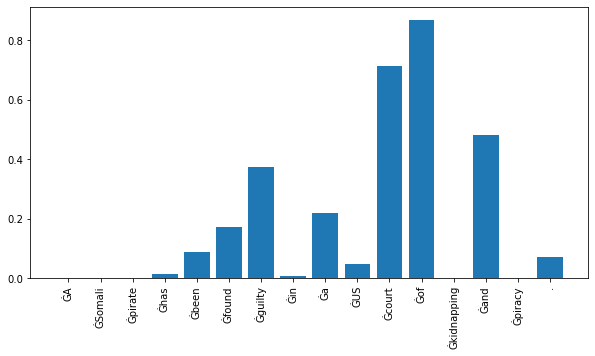

 Masked input:   All of this was about the problems in Somalia."It is said to be the first piracy trial in the US in decades.
 Summary:   "I'm not a pirate, I'm a human rights activist," said former US Attorney General Eric Holder as he defended a group of pirates accused of piracy in the US. 



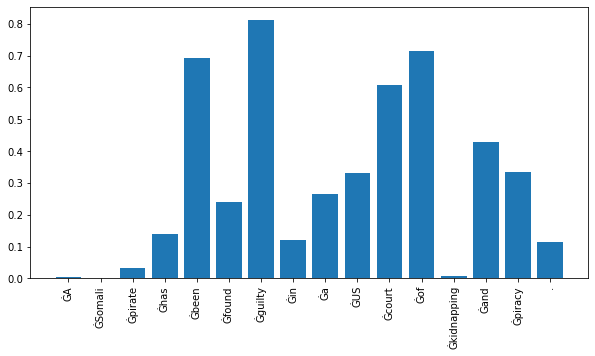

 Masked input:  The vessel, which was carrying food aid, was seized by the four pirates in April 2009.Capt Phillips then told his crew to lock themselves in a cabin and surrendered himself to safeguard his men.He was later taken hostage in an enclosed lifeboat that was soon shadowed by US warships and a helicopter.The stand-off only ended several days later when Navy sharpshooters killed three of the pirates, saving the captain.

 Summary:   The US Navy has released the video of the moment Captain David Phillips, who was held hostage by pirates in the Mediterranean Sea, was rescued. 



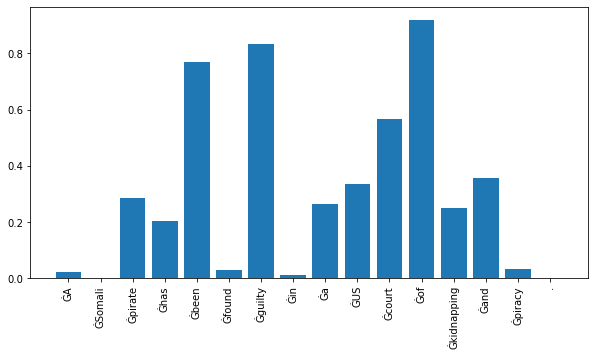

 Masked input:  The vessel, which was carrying food aid, was seized by the four pirates in April 2009.Capt Phillips then told his crew to lock themselves in a cabin and surrendered himself to safeguard his men.
 Summary:   The Royal Navy has confirmed it has captured the HMS Victory from the Somali pirates, after the captain, Captain David Phillips, surrendered. 



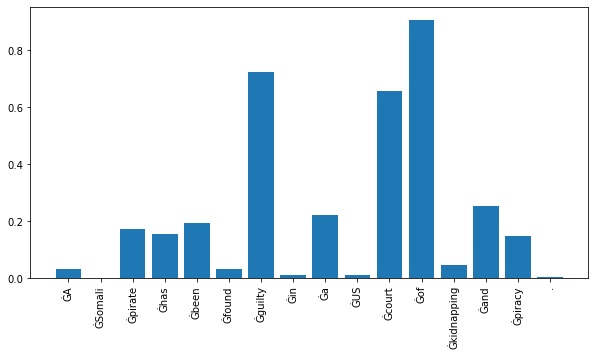

 Masked input:  The vessel, which was carrying food aid, was seized by the four pirates in April 2009.
 Summary:   The BBC has obtained the latest details of the operation to retake the Liberian ship, the Sulu, seized by pirates in the Mediterranean. 



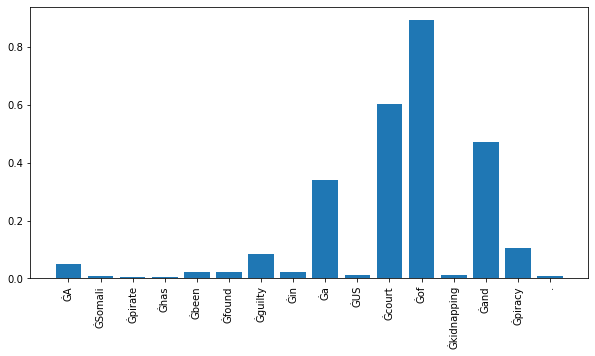

 Masked input:  Capt Phillips then told his crew to lock themselves in a cabin and surrendered himself to safeguard his men.
 Summary:   The Battle of the Somme was fought between the British and Irish armies in the early 18th Century, with the loss of more than 100 lives. 



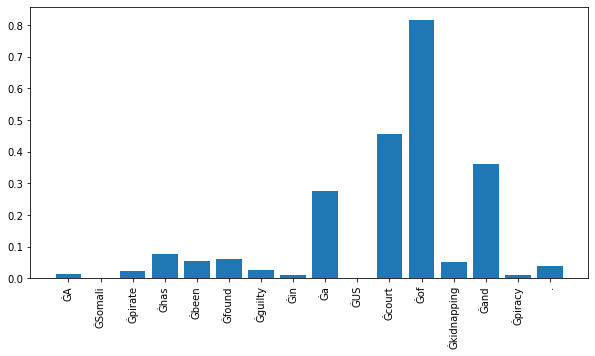

 Masked input:  He was later taken hostage in an enclosed lifeboat that was soon shadowed by US warships and a helicopter.The stand-off only ended several days later when Navy sharpshooters killed three of the pirates, saving the captain.

 Summary:   The US Navy has launched an operation to rescue the captain of a fishing boat that was seized by pirates off the coast of Somalia. 



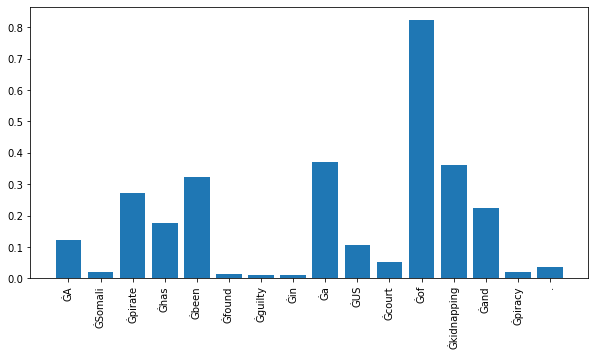

 Masked input:  He was later taken hostage in an enclosed lifeboat that was soon shadowed by US warships and a helicopter.
 Summary:   A man has been taken hostage by a US Navy helicopter after a gun battle in the Irish Sea. 



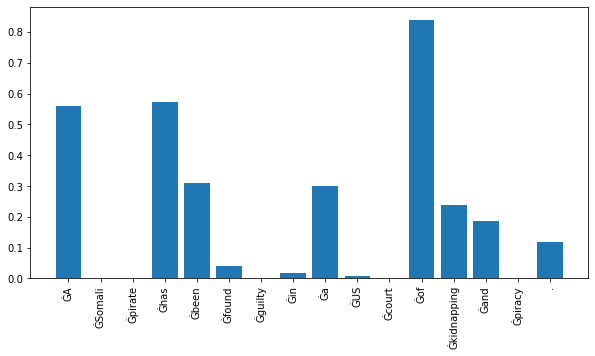

 Masked input:  The stand-off only ended several days later when Navy sharpshooters killed three of the pirates, saving the captain.

 Summary:   The Royal Navy and the US Navy were on the verge of a major stand-off with pirates in the waters off the coast of Somalia in the early hours of the morning. 



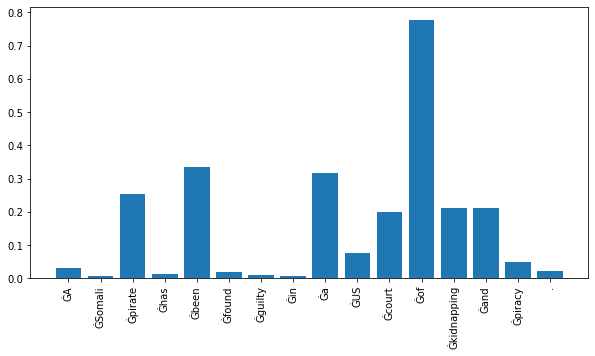

In [24]:
d=0
d_limit=4
M = len(fm)
clust_index=M-2
reference_evaluation(M)
masking_experiment(clust_index,d,d_limit,np.array(feature_names),M)